### Import Libraries

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
import shap

# Display options

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)


C:\Users\Usama\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1

### Load Dataset

In [2]:
# Import datasets

with open("census-bureau.columns", "r") as c:
    columns = [line.strip() for line in c.readlines()]

df = pd.read_csv("census-bureau.data", 
                 header = None, 
                 names = columns, 
                 sep = ",")

print(df.shape)

df.head()

(199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [3]:
# Check data types for every column

print(df.dtypes)

age                                             int64
class of worker                                object
detailed industry recode                        int64
detailed occupation recode                      int64
education                                      object
wage per hour                                   int64
enroll in edu inst last wk                     object
marital stat                                   object
major industry code                            object
major occupation code                          object
race                                           object
hispanic origin                                object
sex                                            object
member of a labor union                        object
reason for unemployment                        object
full or part time employment stat              object
capital gains                                   int64
capital losses                                  int64
dividends from stocks       

### Data Cleaning

In [13]:

# Check the distribution of '?' and 'Not in universe' in the dataset 

missing_values_percentage = pd.DataFrame([
    {
        "column": col,
        "?_percentage": (df[col].astype(str).eq("?").sum() / len(df)) * 100,
        "not_in_universe_percentage": (df[col].astype(str).str.contains("Not in universe", case=False, na=False).sum() / len(df)) * 100,
        "total_missing": (df[col].astype(str).str.contains(r"(Not in universe|\?)", case = False, na = False).sum()/len(df)) * 100
    }
    for col in df.columns
])

missing_values_percentage = missing_values_percentage.sort_values(by="not_in_universe_percentage", ascending=False).reset_index(drop=True) 


C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2284097815.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "total_missing": (df[col].astype(str).str.contains(r"(Not in universe|\?)", case = False, na = False).sum()/len(df)) * 100
C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2284097815.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "total_missing": (df[col].astype(str).str.contains(r"(Not in universe|\?)", case = False, na = False).sum()/len(df)) * 100
C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2284097815.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "total_missing": (df[col].astype(str).str.contains(r"(Not in universe|\?)", case = False, na = False).sum()/len(df)) * 100
C:\Users\Usama\AppData\Local

In [14]:
print(missing_values_percentage[["column","?_percentage"]].sort_values(by="?_percentage", ascending=False))

                                        column  ?_percentage
12              migration code-move within reg     49.967172
14                migration code-change in msa     49.967172
11               migration prev res in sunbelt     49.967172
13                migration code-change in reg     49.967172
15                     country of birth father      3.364524
23                     country of birth mother      3.066814
16                       country of birth self      1.700556
3                  state of previous residence      0.354846
27                    detailed industry recode      0.000000
28                  detailed occupation recode      0.000000
29                                   education      0.000000
30                               wage per hour      0.000000
31                                marital stat      0.000000
32                                        race      0.000000
0   fill inc questionnaire for veteran's admin      0.000000
25                      

In [15]:
print(missing_values_percentage[["column","not_in_universe_percentage"]].sort_values(by="not_in_universe_percentage", ascending=False))

                                        column  not_in_universe_percentage
0   fill inc questionnaire for veteran's admin                   99.005628
1                      reason for unemployment                   96.957744
2                   enroll in edu inst last wk                   93.694962
3                  state of previous residence                   92.094646
4                 region of previous residence                   92.094646
5                      member of a labor union                   90.445212
6                      family members under 18                   72.288408
7                live in this house 1 year ago                   50.726984
8                          major industry code                   50.462353
9                        major occupation code                   50.462353
10                             class of worker                   50.242328
11               migration prev res in sunbelt                   42.127474
13                migrati

In [16]:
print(missing_values_percentage[["column","total_missing"]].sort_values(by="total_missing", ascending=False))

                                        column  total_missing
0   fill inc questionnaire for veteran's admin      99.005628
1                      reason for unemployment      96.957744
2                   enroll in edu inst last wk      93.694962
3                  state of previous residence      92.449492
11               migration prev res in sunbelt      92.094646
4                 region of previous residence      92.094646
5                      member of a labor union      90.445212
6                      family members under 18      72.288408
13                migration code-change in reg      50.726984
12              migration code-move within reg      50.726984
14                migration code-change in msa      50.726984
7                live in this house 1 year ago      50.726984
8                          major industry code      50.462353
9                        major occupation code      50.462353
10                             class of worker      50.242328
15      

In [ ]:
'''
For the columns with more than 70% ? or Not in Universe values, it would make sense
to drop them because they would add uncesessary noise to the data. 
For columns with more than 50% ? or Not in Universe values, for example major industry and occupation recode,
it made sense to drop them because we have their proxy variables. We did not have the salaries earned for each 
occupation and/or industry, so ranking them based on how lucrative an industry is not possibe. The maximum information
we can get out of these variables is the employability, which is already covered with the employment column.

'''

# Drop columns with high percentage of 'Not in universe' or '?'

cols_to_drop = [
    "fill inc questionnaire for veteran's admin",
    "reason for unemployment",
    "enroll in edu inst last wk",
    "state of previous residence",
    "region of previous residence",
    "member of a labor union",
    "family members under 18",
    "major occupation code",
    "major industry code",
    "class of worker",
    "migration prev res in sunbelt",
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "live in this house 1 year ago"
]

df = df.drop(columns = cols_to_drop)

# Replace the remaining '?' with NaN

df.replace('?', np.nan, inplace = True)
df.dropna(inplace = True)



### Exploratory Data Analysis

In [ ]:
'''
Checking for weighted class imbalance is important to support our assumption that the dataset is 
actually representative of the population. 

'''

## Check for class imbalance

print(df['label'].value_counts()/len(df)*100)

## Check for class imbalance using weights

weighted = df.groupby('label')['weight'].sum()
weighted = (weighted/weighted.sum())*100
print(weighted) 

print('Classes are highly imbalanced ~ 16.7 ratio')

label
- 50000.    93.882942
50000+.      6.117058
Name: count, dtype: float64
label
- 50000.    93.693483
50000+.      6.306517
Name: weight, dtype: float64
Classes are highly imbalanced ~ 16.7 ratio


In [19]:
# Check for category distribution 

raw_numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
raw_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

## Categorical colums

summary_category = []

for col in raw_categorical_cols:
    value_counts = df[col].value_counts(normalize=False, dropna=False) 
    value_perc = df[col].value_counts(normalize=True, dropna=False) * 100

    for category, count in value_counts.items():
        summary_category.append({
            'column': col,
            'category': category,
            'count': count,
            'percent': round(value_perc[category], 2)
        })

cat_summary_df = pd.DataFrame(summary_category)

print(cat_summary_df)

          column                                     category   count  percent
0      education                         High school graduate   46229    24.28
1      education                                     Children   45930    24.12
2      education                   Some college but no degree   26496    13.92
3      education                   Bachelors degree(BA AB BS)   18668     9.80
4      education                            7th and 8th grade    7505     3.94
..           ...                                          ...     ...      ...
228  citizenship  Foreign born- U S citizen by naturalization    4621     2.43
229  citizenship  Native- Born in Puerto Rico or U S Outlying    1479     0.78
230  citizenship    Native- Born abroad of American Parent(s)    1333     0.70
231        label                                     - 50000.  178755    93.88
232        label                                      50000+.   11647     6.12

[233 rows x 4 columns]


In [20]:
## Numerical columns

num_summary_df = df[raw_numeric_cols].describe().T 
num_summary_df['median'] = df[raw_numeric_cols].median()
num_summary_df['mode'] = df[raw_numeric_cols].mode().iloc[0] 

print(num_summary_df)

                                    count         mean          std    min      25%      50%      75%      max   median   mode
age                              190402.0    34.066979    22.086592   0.00    15.00    33.00    49.00     90.0    33.00   34.0
detailed industry recode         190402.0    15.407963    18.072428   0.00     0.00     0.00    33.00     51.0     0.00    0.0
detailed occupation recode       190402.0    11.408236    14.495127   0.00     0.00     0.00    26.00     46.0     0.00    0.0
wage per hour                    190402.0    56.155849   275.226176   0.00     0.00     0.00     0.00   9999.0     0.00    0.0
capital gains                    190402.0   422.437868  4601.891942   0.00     0.00     0.00     0.00  99999.0     0.00    0.0
capital losses                   190402.0    36.965961   270.102013   0.00     0.00     0.00     0.00   4608.0     0.00    0.0
dividends from stocks            190402.0   191.646789  1973.895031   0.00     0.00     0.00     0.00  99999.0 

### Feature Engineering

In [ ]:
'''
To reduce sparsity, it was important to go for regions instead of countries.
'''

# Group countries into regions

def group_country(country):
    if country in ['United-States', 'Puerto-Rico', 'Outlying-U S (Guam USVI etc)']:
        return 'US/Territory'
    elif country in ['Canada', 'Mexico']:
        return 'North America'
    elif country in ['Columbia','Peru','Dominican-Republic','Cuba','El-Salvador',
                     'Guatemala','Ecuador','Nicaragua','Trinadad&Tobago','Jamaica',
                     'Honduras','Panama','Haiti']:
        return 'Latin America/Caribbean'
    elif country in ['Germany','Scotland','Italy','Poland','England','Ireland',
                     'Hungary','Yugoslavia','Portugal','France','Greece','Holand-Netherlands']:
        return 'Europe'
    elif country in ['Vietnam','Philippines','Japan','South Korea','Cambodia',
                     'China','Taiwan','India','Hong Kong','Thailand','Laos','Iran']:
        return 'Asia'
    else:
        return 'Other'

In [22]:
# Target Variable

df['is_greater_50k'] = df['label'].apply(lambda x: 1 if x == "50000+." else 0)

### Binning categorical variables

df['age_bins'] = np.where(df['age'] < 20, '0-20',
                 np.where(df['age'] < 40, '20-40',
                 np.where(df['age'] < 60, '40-60', '60+')))

### Education bins 

df['education_bin'] = np.where(df['education'].str.contains('Less than|1st|2nd|3rd|4th|5th|6th|7th|8th|Children'), 'No education',
                   np.where(df['education'].str.contains('9th|10th|11th'), 'High School',
                   np.where(df['education'].str.contains('High school|12th grade'), 'High School',
                   np.where(df['education'].str.contains('Some college|Associates'), 'Some College / Associates',
                   np.where(df['education'].str.contains('Bachelors'), 'Bachelors',
                   np.where(df['education'].str.contains('Masters'), 'Masters',
                   np.where(df['education'].str.contains('Prof school|Doctorate'), 'Graduate / Doctorate',
                   'No education')))))))

### Marital status bins

df['marital_bin'] = np.where(df['marital stat'].str.contains('Married'), 'Married',
                    np.where(df['marital stat'].str.contains('Never married'), 'Never Married',
                    'Previously Married'))

### Race bins

df['race_bin'] = np.where(df['race'] == 'Amer Indian Aleut or Eskimo', 'Other', df['race'])

### Hispanic bins 

df['hispanic_bin'] = np.where(df['hispanic origin'].str.contains('All other'), 'Non-Hispanic',
                     np.where(df['hispanic origin'].isin(['Mexican-American', 'Mexican (Mexicano)', 'Chicano']), 'Mexican',
                     np.where(df['hispanic origin'].isin(['Central or South American', 'Puerto Rican', 'Other Spanish', 'Cuban']), 'Other Hispanic',
                     'Unknown')))

### Employment bins 

df['employment_bin'] = np.where(df['full or part time employment stat'].isin(['Full-time schedules', 
                                                                               'Unemployed full-time',
                                                                               'PT for econ reasons usually FT',
                                                                               'PT for non-econ reasons usually FT']), 'Full-time',
                       np.where(df['full or part time employment stat'].isin(['PT for econ reasons usually PT', 
                                                                              'Unemployed part-time']), 'Part-time',
                       np.where(df['full or part time employment stat'].isin(['Children or Armed Forces', 
                                                                              'Not in labor force']), 'Unemployed', 'Other')))

### Family bins 

df['family_bin'] = np.where(df['detailed household and family stat'].isin(['Householder', 'Nonfamily householder']), 'Head of Household',
                   np.where(df['detailed household and family stat'].isin(['Spouse of householder', 
                                                                           'Child 18+ spouse of subfamily RP', 
                                                                           'Other Rel 18+ spouse of subfamily RP', 
                                                                           'Child <18 spouse of subfamily RP']), 'Spouse',
                   np.where(df['detailed household and family stat'].isin(['Child <18 never marr not in subfamily',
                                                                           'Grandchild <18 never marr child of subfamily RP',
                                                                           'Child under 18 of RP of unrel subfamily',
                                                                           'Other Rel <18 never marr child of subfamily RP',
                                                                           'Other Rel <18 never marr not in subfamily',
                                                                           'Child <18 never marr RP of subfamily',
                                                                           'Grandchild <18 never marr not in subfamily',
                                                                           'Grandchild <18 never marr RP of subfamily',
                                                                           'Grandchild <18 ever marr not in subfamily',
                                                                           'Other Rel <18 ever marr not in subfamily']), 'Children (<18)',
                   np.where(df['detailed household and family stat'].isin(['Child 18+ never marr Not in a subfamily',
                                                                           'Child 18+ ever marr Not in a subfamily',
                                                                           'Child 18+ never marr RP of subfamily',
                                                                           'Child 18+ ever marr RP of subfamily']), 'Children (18+)',
                   np.where(df['detailed household and family stat'].isin(['Other Rel 18+ ever marr RP of subfamily',
                                                                           'Other Rel 18+ never marr not in subfamily',
                                                                           'Other Rel 18+ ever marr RP of subfamily',
                                                                           'Other Rel 18+ never marr RP of subfamily']), 'Non-family',
                   np.where(df['detailed household and family stat'].isin(['Grandchild 18+ never marr not in subfamily']), 'Non-family',
                   np.where(df['detailed household and family stat'].isin(['Secondary individual']), 'Non-family',
                   np.where(df['detailed household and family stat'].isin(['In group quarters']), 'Non-family',
                   'Non-family'))))))))

### Household summary bins 

df['household_bin'] = np.where(df['detailed household summary in household'].isin(['Householder']), 'Householder',
                      np.where(df['detailed household summary in household'].isin(['Child under 18 never married',
                                                                                   'Child under 18 ever married']), 'Children (<18)',
                      np.where(df['detailed household summary in household'].isin(['Spouse of householder']), 'Spouse',
                      np.where(df['detailed household summary in household'].isin(['Child 18 or older']), 'Children (18+)', 'Other'                      
                               ))))

### Country regions

df['region_father'] = df['country of birth father'].apply(group_country)
df['region_mother'] = df['country of birth mother'].apply(group_country)
df['region_self'] = df['country of birth self'].apply(group_country)

### Is citizen?

df['is_native'] = np.where(df['citizenship'].str.contains('Native', na=False), 1, 0)

### Is tax filer?

df['is_tax_filer'] = np.where(df['tax filer stat'].str.contains("Nonfiler"), 0, 1)

### Net investment income and log net investment income 

df[['capital gains', 'capital losses', 'dividends from stocks']] = df[['capital gains', 'capital losses', 'dividends from stocks']].fillna(0)

df['investment_income'] = (df['capital gains'] - df['capital losses']) + df['dividends from stocks']

df['log_investment_income'] = np.log1p(df['investment_income'].clip(lower = 0))

### Log Wage Per Hour

df['log_wage_per_hour'] = np.log1p(df['wage per hour'].clip(lower = 0))




In [23]:
# Binned categorical columns 

## Categorical columns

binned_categorical_cols = ['age_bins','education_bin', 'marital_bin', 'race_bin', 
                           'hispanic_bin', 'employment_bin', 'family_bin', 'household_bin',]

summary_category_binned = []

for col in binned_categorical_cols:
    value_counts = df[col].value_counts(normalize=False, dropna=False) 
    value_perc = df[col].value_counts(normalize=True, dropna=False) * 100

    for category, count in value_counts.items():
        summary_category_binned.append({
            'column': col,
            'category': category,
            'count': count,
            'percent': round(value_perc[category], 2)
        })

binned_summary_df = pd.DataFrame(summary_category_binned)

print(binned_summary_df)

            column                   category   count  percent
0         age_bins                       0-20   58945    30.96
1         age_bins                      20-40   58036    30.48
2         age_bins                      40-60   44406    23.32
3         age_bins                        60+   29015    15.24
4    education_bin                High School   68109    35.77
5    education_bin               No education   59046    31.01
6    education_bin  Some College / Associates   35759    18.78
7    education_bin                  Bachelors   18668     9.80
8    education_bin                    Masters    6113     3.21
9    education_bin       Graduate / Doctorate    2707     1.42
10     marital_bin              Never Married   83351    43.78
11     marital_bin                    Married   81974    43.05
12     marital_bin         Previously Married   25077    13.17
13        race_bin                      White  159995    84.03
14        race_bin                      Black   19650  

In [24]:
# Separate feature list

cols_for_prediction = ['is_greater_50k','age_bins','education_bin', 'marital_bin', 'race_bin', 
                'hispanic_bin', 'employment_bin', 'family_bin', 'household_bin', 
                'is_native', 'is_tax_filer', 'log_investment_income',
                'weeks worked in year', 'veterans benefits', 'own business or self employed', 'region_father',
                'region_mother', 'region_self', 'num persons worked for employer', 'sex', 'log_wage_per_hour']

df_predictive = df[cols_for_prediction].copy()

In [25]:
# Feature lists by data type

binary_cols = ['is_native', 'is_tax_filer']

numeric_cols = ['log_investment_income', 'weeks worked in year',
                'veterans benefits', 'own business or self employed', 'num persons worked for employer', 'log_wage_per_hour']

categorical_cols = ['age_bins', 'education_bin', 'marital_bin', 'race_bin', 'hispanic_bin', 'employment_bin', 'family_bin', 'household_bin',
                    'region_father', 'region_mother', 'region_self', 'sex']


C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2432403261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2432403261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2432403261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Usama\AppData\Local\Temp\ipykernel_8536\2432403261.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

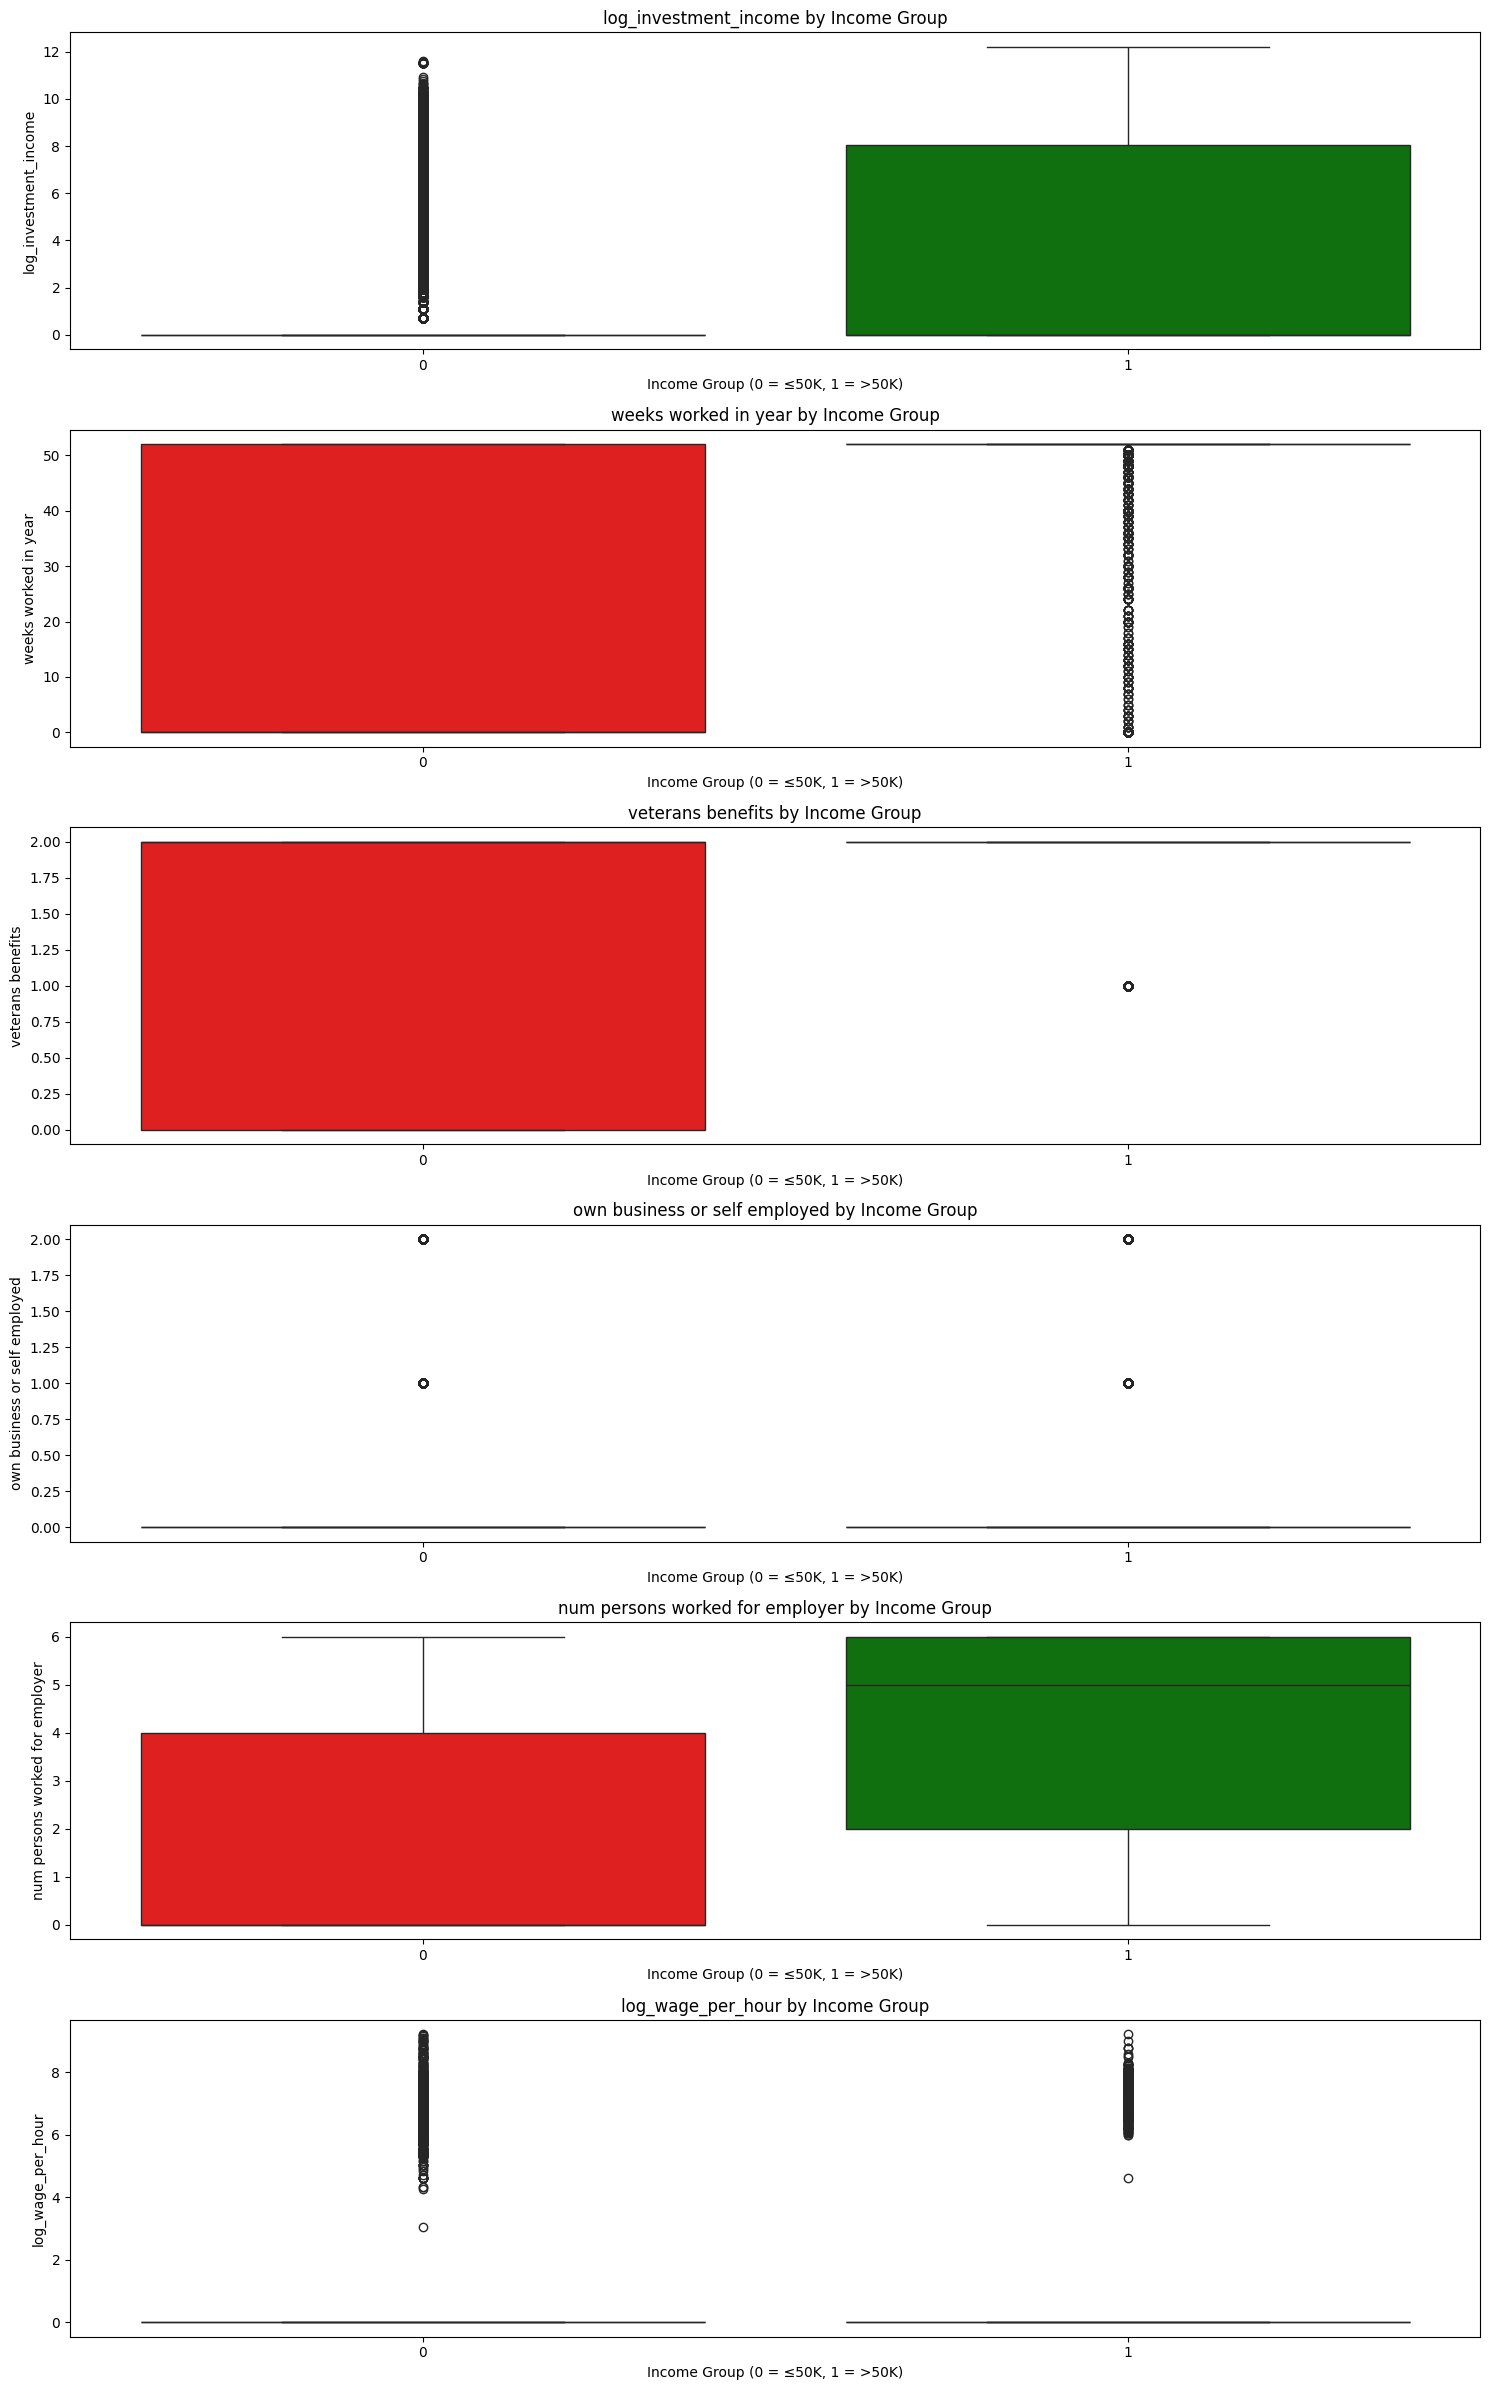

In [ ]:
'''
These boxplots show us some very interesting insights. Based on what I can observe from these plots: 
- log_investment_income could be a strong differentiator for income groups because people with >50k income consistently
show high investment income. 
- weeks worked per year shows that people with >50k work many more weeks per year. It can be a strong differentiator too
- Hardly anyone with high income shows veterans benefits. It is more associated with low income groups. Might not be a good
differentiator
- Own business shows up occasionally among high earners. Low income groups rarely show this trait. Might not be a good differentiator
- Number of persons working for each employer can be a strong predictor because high income individuals tend to work at firms with more 
employees. 
- High hourly wage is almost exclusively in the >50k category

In summary, hourly wage, number of employees, weeks worked, and investment income can be good predictors
'''

numeric_cols = df_predictive.select_dtypes(include=['int64', 'float64']).columns.drop("is_greater_50k", errors='ignore')

plt.figure(figsize=(15, len(numeric_cols) * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(
        data=df,
        x="is_greater_50k",
        y=col,
        palette={"0": "red", "1": "green"}   # mapping 0 → red, 1 → green
    )
    plt.title(f"{col} by Income Group", fontsize=12)
    plt.xlabel("Income Group (0 = ≤50K, 1 = >50K)")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


### Data Visualisation for Feature Understanding

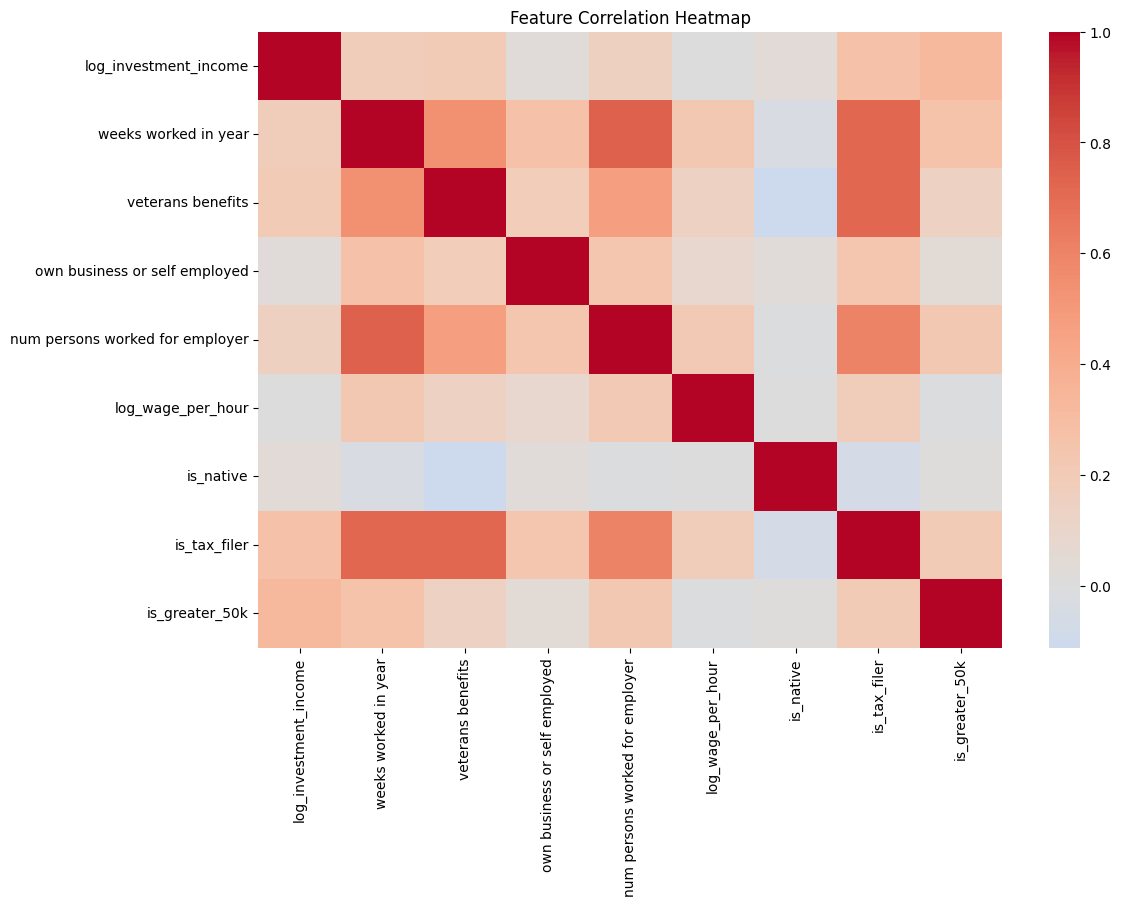

In [ ]:
'''
This supports my hypothesis from the boxplots. Investment income, weeks worked, hourly wage, and tax filers have the strongest correlation
with high earners (>50k). Employer size is moderately correlated. Veterans benefits and is_native show negligible correlation

'''

## Numeric and Binary Feature Correlation with Target Metric

plt.figure(figsize=(12,8))
corr = df_predictive[list(numeric_cols) + list(binary_cols) + ['is_greater_50k']].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

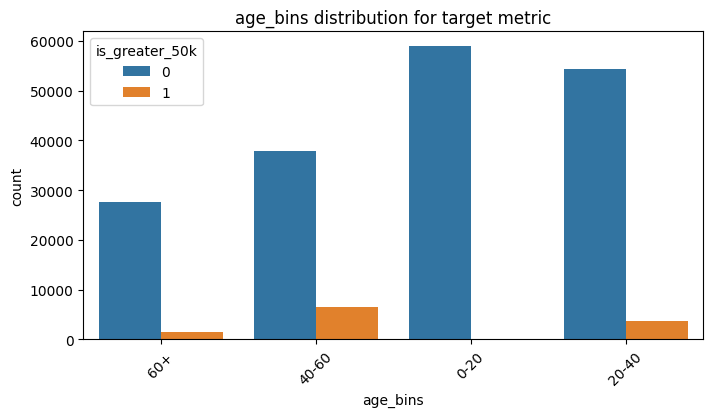

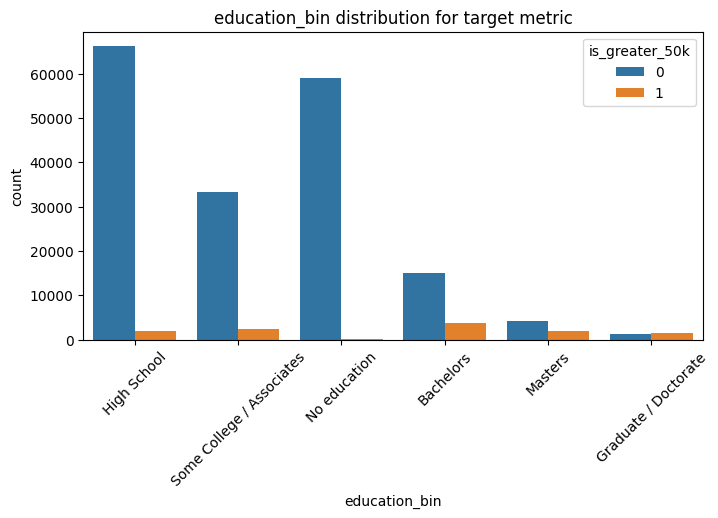

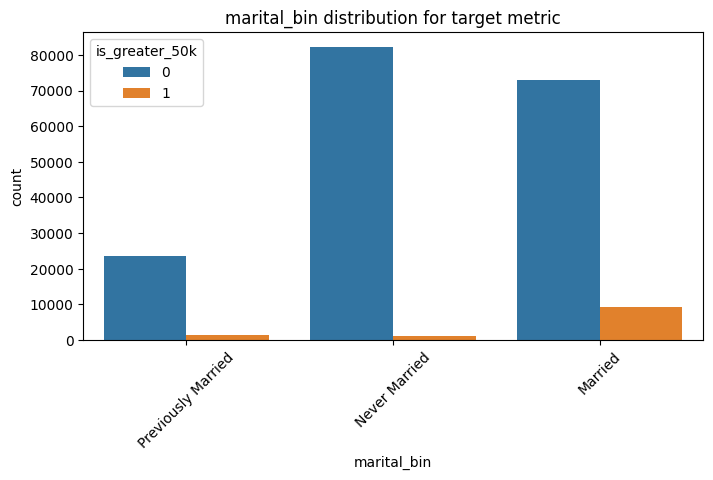

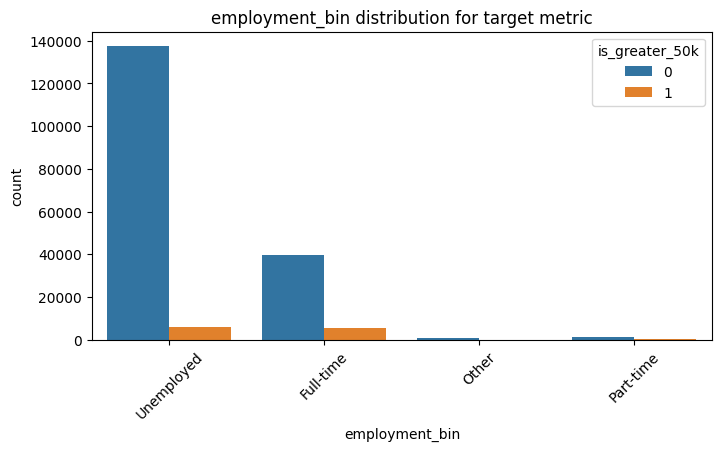

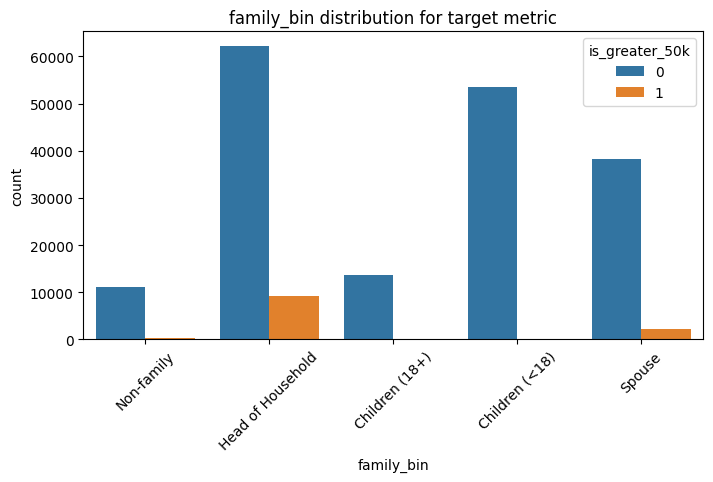

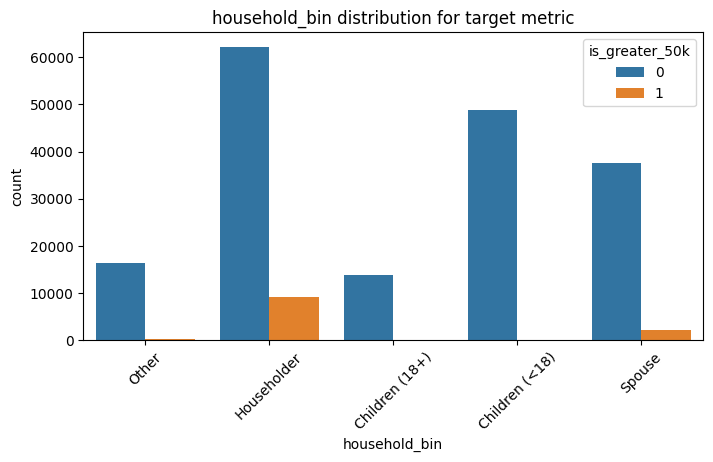

In [ ]:
'''
For categorical features, 
- People in 0-20 are not high earners. People in 40-60 are the highest earners. 
- People who are not educated are not high earners.
- Married couples are high earners, possibly because of pooling of income
- Full-time and unemployed people are majorly high earners. This is ambiguous.
- We can use either household or family bin for modeling. They are basically the same

'''

# Distribution of Target Metric for each bin of categorical features

key_bins = ['age_bins','education_bin','marital_bin','employment_bin','family_bin','household_bin']
for col in key_bins:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='is_greater_50k')
    plt.title(f"{col} distribution for target metric")
    plt.xticks(rotation=45)
    plt.show()

### Data Prepartion for Model Training

In [58]:
# Split the data into training and testing

x = df_predictive.drop(columns = ['is_greater_50k'])
y = df_predictive['is_greater_50k']

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.2, stratify = y, random_state = 42)

In [ ]:
''' 
It is important to maintain the intrinsic hierarchy for ordinal variables.

'''

# Manual Label Encoding 

age_map = {'0-20': 0, '20-40': 1, '40-60': 2, '60+': 3}
edu_map = {'No education': 0, 'High School': 1, 'Some College / Associates': 2,
           'Bachelors': 3, 'Masters': 4, 'Graduate / Doctorate': 5}
emp_map = {'Unemployed': 0, 'Other': 1, 'Part-time': 2, 'Full-time': 3}

# Mapping values on ordinal bins

for _df in (x_train, x_test):
    _df['age_bins']        = _df['age_bins'].map(age_map).fillna(-1).astype('int8')
    _df['education_bin']   = _df['education_bin'].map(edu_map).fillna(-1).astype('int8')
    _df['employment_bin']  = _df['employment_bin'].map(emp_map).fillna(-1).astype('int8')

In [ ]:
''' 
For nominal variables, there is no intrinsic hierarchy so one-hot encoding
'''

# One-Hot encoding 

ordinal_cols = ['age_bins', 'education_bin', 'employment_bin']
nominal_cols = ['marital_bin', 'race_bin', 'hispanic_bin', 'family_bin',
                'region_father', 'region_mother', 'region_self', 'sex']

# Define ColumnTransformer (Only for OneHotEncoding)
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", "passthrough", ordinal_cols),
        ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output= False), nominal_cols),
        ("num", "passthrough", numeric_cols),
        ("bin", "passthrough", binary_cols),
    ]
)

# Fit and transform preprocessor
X_train_enc = preprocessor.fit_transform(x_train)
X_test_enc = preprocessor.transform(x_test)

# Fix features list
ord_features = ordinal_cols
ohe_features = preprocessor.named_transformers_["ohe"].get_feature_names_out(nominal_cols)
ohe_features = [f.replace("[", "_").replace("]", "").replace("<", "_lt_").replace(">", "_gt_") for f in ohe_features]
all_features = list(ord_features) + list(ohe_features) + list(numeric_cols) + list(binary_cols)

X_train_enc = pd.DataFrame(X_train_enc, columns=all_features, index=x_train.index)
X_test_enc = pd.DataFrame(X_test_enc, columns=all_features, index=x_test.index)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)
X_train_enc.head()

Encoded train shape: (152321, 49)
Encoded test shape: (38081, 49)


,age_bins,education_bin,employment_bin,marital_bin_Married,marital_bin_Never Married,marital_bin_Previously Married,race_bin_Asian or Pacific Islander,race_bin_Black,race_bin_Other,race_bin_White,hispanic_bin_Mexican,hispanic_bin_Non-Hispanic,hispanic_bin_Other Hispanic,hispanic_bin_Unknown,family_bin_Children (18+),family_bin_Children (_lt_18),family_bin_Head of Household,family_bin_Non-family,family_bin_Spouse,household_bin_Children (18+),household_bin_Children (_lt_18),household_bin_Householder,household_bin_Other,household_bin_Spouse,region_father_Asia,region_father_Europe,region_father_Latin America/Caribbean,region_father_North America,region_father_US/Territory,region_mother_Asia,region_mother_Europe,region_mother_Latin America/Caribbean,region_mother_North America,region_mother_US/Territory,region_self_Asia,region_self_Europe,region_self_Latin America/Caribbean,region_self_North America,region_self_US/Territory,sex_Female,sex_Male,log_investment_income,weeks worked in year,veterans benefits,own business or self employed,num persons worked for employer,log_wage_per_hour,is_native,is_tax_filer
6271,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.334472,52.0,2.0,0.0,6.0,0.000000,1.0,1.0
72772,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0
60428,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,25.0,2.0,0.0,2.0,0.000000,1.0,1.0
93868,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,52.0,1.0,2.0,1.0,6.552508,1.0,1.0
123201,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,52.0,2.0,0.0,3.0,0.000000,1.0,1.0


### Model Training and Evaluation

In [ ]:
''' 
To get an idea how the model will perform if we keep everything basic. This will give us a threshold to improve on.

The choice of estimators, max_depth etc is good for baseline model. We do not want it to overfit. I have kept the objective as 
binary:logistic because I want the probabilities between 0-1 in case I need to adjust the threshold later because of class imbalance.

'''


# Training the baseline model 

scale_pos_weight = 15.34 # Ratio of class imbalance 

xgb = XGBClassifier(
    n_estimators = 300,         
    max_depth = 6,              
    learning_rate = 0.1,        
    subsample = 0.8,            
    colsample_bytree = 0.8,     
    objective = "binary:logistic",
    scale_pos_weight = scale_pos_weight,  
    eval_metric = "aucpr",
    random_state = 10,
    n_jobs=-1
)

xgb.fit(X_train_enc, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
''' 
The results are what I expected. Precision and recall are high for <50k class. It identifies most >50k earners
which was my main goal. Accuracy is high but irrelevant because it is highly influenced by the majority classs
'''

# Predictions

y_pred  = xgb.predict(X_test_enc)
y_proba = xgb.predict_proba(X_test_enc)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, y_proba))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.989     0.855     0.917     35752
           1      0.277     0.853     0.418      2329

    accuracy                          0.855     38081
   macro avg      0.633     0.854     0.667     38081
weighted avg      0.945     0.855     0.886     38081

ROC-AUC : 0.9345709736872521
Confusion Matrix :
 [[30557  5195]
 [  343  1986]]


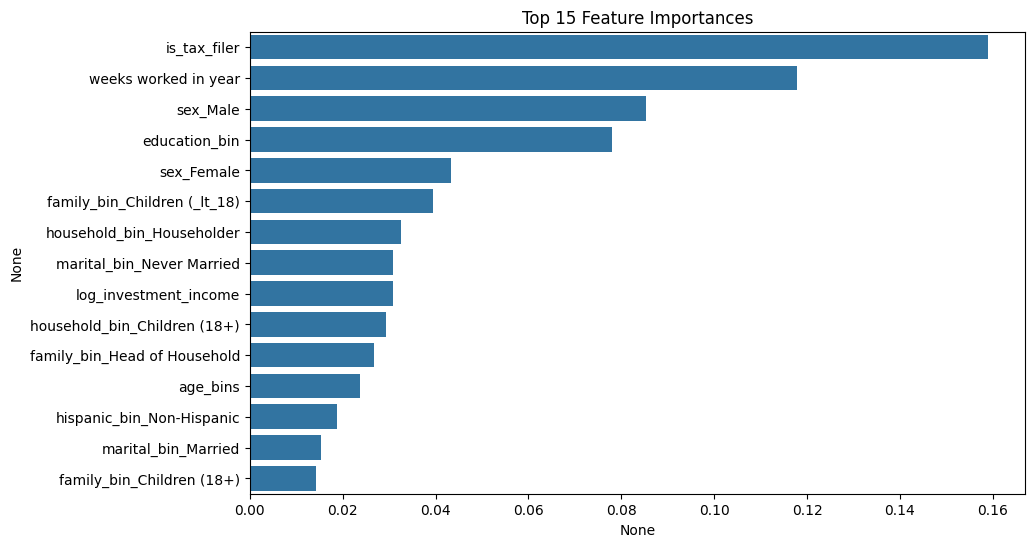

In [ ]:
''' 
The model is most influenced by financial stability signals, i.e. is_tax_filer, education, investment income, steady work 
which was shown in the boxplots too. Family structure and demographics provide additional context that helps separate lower-higher 
classes
'''


# Get feature importances
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=X_train_enc.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances")
plt.show()

In [60]:
''' 
Why undersampling? Because we have a dataset of ~200,000k observations and ~12k observations for the minority class. 
We can afford to do undersampling. The only problem is that if we undersample the majority class, we might lose alot of important
data, which can be fixed by stratified undersampling (the way US census did). Moreover, I plan to use cross validation so the issue of less
data can be mitigated.
'''

# Retrain and fine-tune XGB

## Stratified undersampling for the majority class on the training set

undersample = RandomUnderSampler(sampling_strategy = 1.0, random_state = 42)
X_resampled, y_resampled = undersample.fit_resample(X_train_enc, y_train)

print("Original:", X_train_enc.shape, "Resampled:", X_resampled.shape)
print("Class distribution after resampling:\n", pd.Series(y_resampled).value_counts())


Original: (152321, 49) Resampled: (18636, 49)
Class distribution after resampling:
 is_greater_50k
0    9318
1    9318
Name: count, dtype: int64


In [ ]:
'''
I tried the baseline model again with undersampling instead of scale_pos_weight (keeping every other parameter constant)
and we could see significant improvement in both recall and precision for the minority class. We will go with undersampling instead of 
scale_pos_weight

'''

# Baseline XGBoost resampled

baseline_xgb = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "aucpr", 
    n_estimators = 300,     
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    scale_pos_weight = 1,
    colsample_bytree = 0.8,    
    random_state = 42,
    n_jobs=-1
)

baseline_xgb.fit(X_resampled, y_resampled)

# Evaluate on the original (imbalanced) test set
y_proba_base = baseline_xgb.predict_proba(X_test_enc)[:, 1]
y_pred_base  = (y_proba_base >= 0.5).astype(int)

print("Baseline XGB on Test")
print(classification_report(y_test, y_pred_base, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))


Baseline XGB on Test
              precision    recall  f1-score   support

           0      0.990     0.835     0.906     35752
           1      0.257     0.877     0.397      2329

    accuracy                          0.837     38081
   macro avg      0.624     0.856     0.651     38081
weighted avg      0.946     0.837     0.875     38081

ROC-AUC: 0.9320853374628577
Confusion Matrix:
 [[29838  5914]
 [  287  2042]]


In [64]:
'''
Now that we know that undersampling is the clear winner to handle class imbalance, we run a comprehensive RandomizedCV search to find the best
hyperparameters for the model.
'''

# RandomizedSearchCV

param_dist = {
    "learning_rate":    np.linspace(0.01, 0.2, 8),
    "max_depth":        [3, 4, 5, 6, 7, 8],
    "min_child_weight": [1, 2, 3, 5, 7, 10],
    "subsample":        np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "gamma":            [0, 0.5, 1, 2, 3],
    "reg_alpha":        [0.0, 0.1, 0.5, 1.0, 2.0],
    "reg_lambda":       [0.5, 1.0, 2.0, 5.0, 10.0],
    "n_estimators":     [400, 600, 800, 1000, 1200]
}

xgb_for_search = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    estimator = xgb_for_search,
    param_distributions = param_dist,
    n_iter = 25,                 # moderate search size
    scoring = "recall",
    cv = 5,                      # CV on undersampled train data
    random_state = 42,
    n_jobs = -1,
    refit = True                 # refit on full undersampled train with best params
)

rs.fit(X_resampled, y_resampled)

print("Best Params (RandomizedSearch)")
print(rs.best_params_)
print("Best CV AUC:", rs.best_score_)

best_xgb = rs.best_estimator_


Best Params (RandomizedSearch)
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.0, 'n_estimators': 800, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.7}
Best CV AUC: 0.889247176205253


In [ ]:
# Final evaluation on the original (imbalanced) test set

y_proba = best_xgb.predict_proba(X_test_enc)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("\n Tuned XGB on Test")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Tuned XGB on Test
              precision    recall  f1-score   support

           0      0.992     0.826     0.901     35752
           1      0.251     0.894     0.392      2329

    accuracy                          0.830     38081
   macro avg      0.621     0.860     0.647     38081
weighted avg      0.946     0.830     0.870     38081

ROC-AUC: 0.9349740233780712
Confusion Matrix:
 [[29533  6219]
 [  246  2083]]


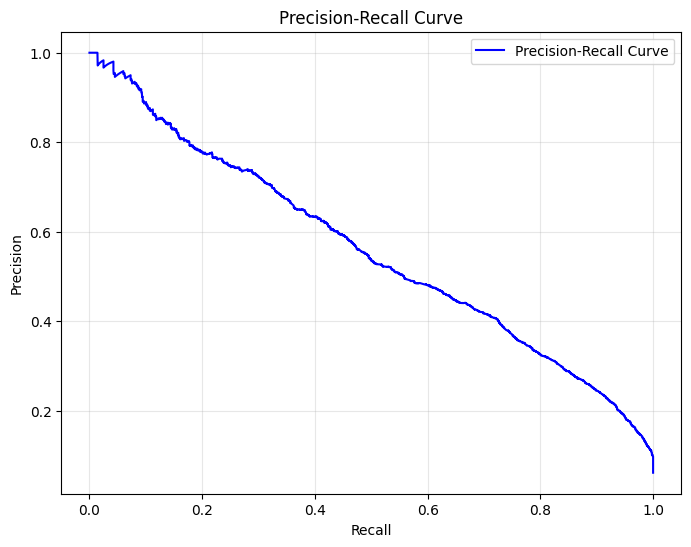

       threshold  precision    recall
0       0.000000   0.061159  1.000000
1       0.001245   0.061161  1.000000
2       0.001249   0.061162  1.000000
3       0.001258   0.061178  1.000000
4       0.001277   0.061182  1.000000
...          ...        ...       ...
16143   0.995445   1.000000  0.002147
16144   0.995452   1.000000  0.001717
16145   0.995492   1.000000  0.000859
16146   0.995521   1.000000  0.000429
16147   0.996140   1.000000  0.000000

[16148 rows x 3 columns]


In [ ]:
''' 
Changing thresholds do not significantly change the precision

'''

# Compute precision, recall, thresholds

prec, rec, thresh = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, label='Precision-Recall Curve', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

thresholds_df = pd.DataFrame({'threshold': [0.0] + list(thresh), 'precision': prec, 'recall': rec})
print(thresholds_df)
thresholds_df.to_csv("thresholds.csv")


### Feature Importance and SHAP

In [ ]:
''' 
In a case study like this, feature importance is not enough. We need the marginal effects that each variable
has on the predictions for better inpretability. Therefore, I calculated the SHAP values to see which feature has 
the most marginal effect on predictions. 
'''

# Top-20 features by gain-based importance from XGBoost 

feat_imp = pd.Series(xgb.feature_importances_, index=X_test_enc.columns)
top20 = feat_imp.sort_values(ascending=False).head(20)

top20 = top20.to_frame("Importance")
top20.index.name = "Features"

print("Top 20 features by XGBoost importance:")
display(top20)

Top 20 features by XGBoost importance:


,Importance
Features,
is_tax_filer,0.158948
weeks worked in year,0.117932
sex_Male,0.085400
education_bin,0.077948
sex_Female,0.043272
family_bin_Children (_lt_18),0.039370
household_bin_Householder,0.032559
marital_bin_Never Married,0.030888
log_investment_income,0.030775


<function matplotlib.pyplot.show(close=None, block=None)>

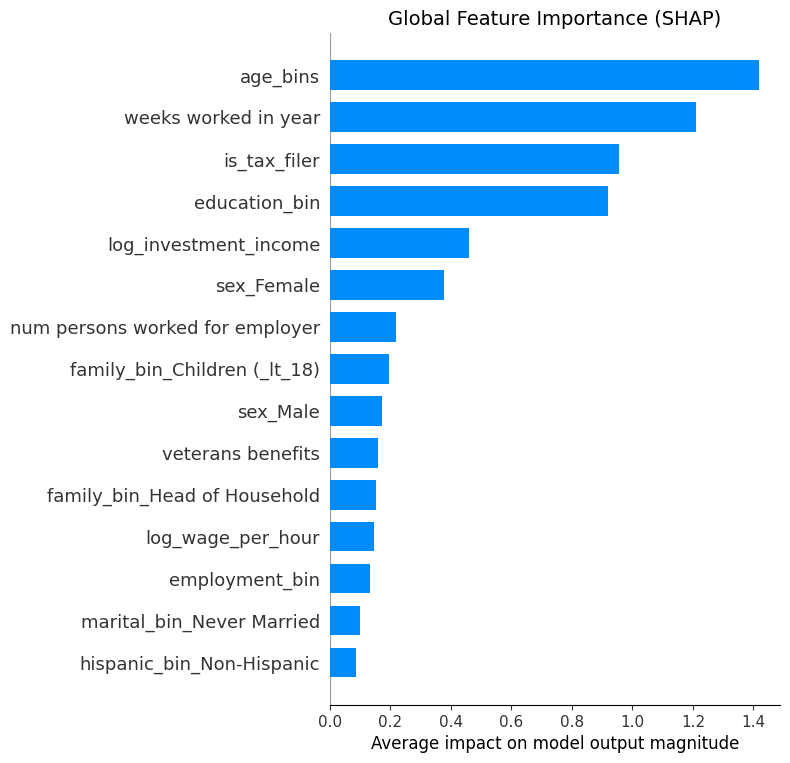

In [56]:
# SHAP values calculation on test set

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_enc)

# Shap-Based Global Feature Importance 

shap.summary_plot(shap_values, X_test_enc, plot_type="bar", max_display=15, show=False)
plt.xlabel("Average impact on model output magnitude", fontsize=12)
plt.title("Global Feature Importance (SHAP)", fontsize=14)
plt.show

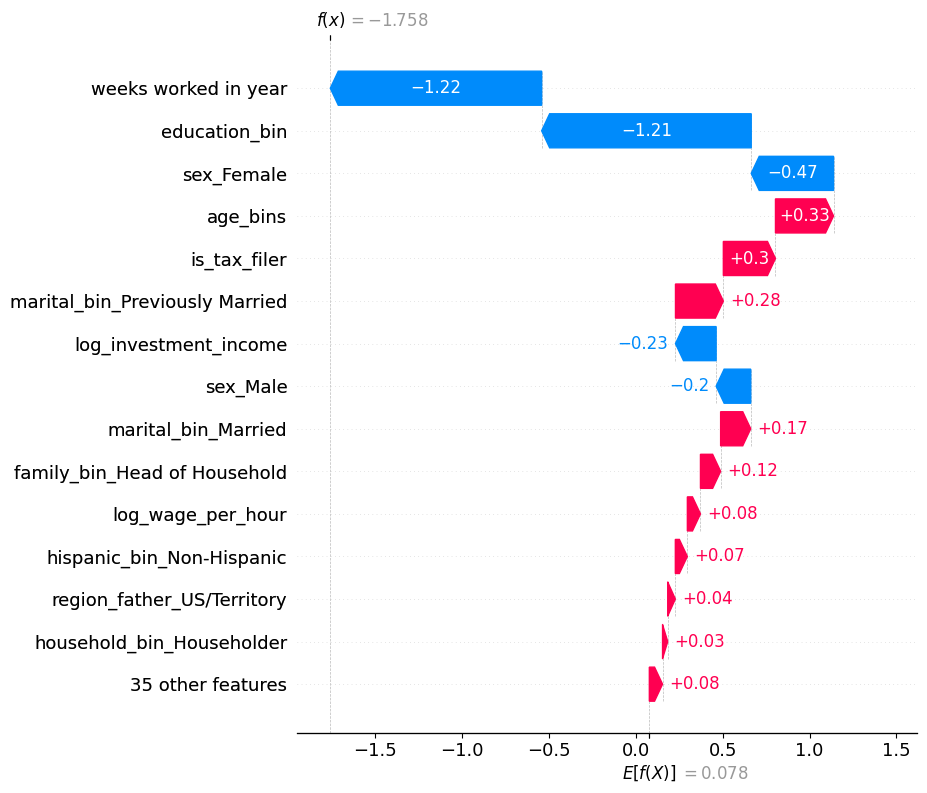

In [ ]:
''' 
Weeks worked per year and education bins are the biggest contributors, i.e. less weeks worked per year and less education 
leads to more people having a low income (<50k). Moreover, Female gender also (slightly) correlates to having an income of
less than 50k. 
Age, tax_filer, and being previously married slightly pushed the probability of having an income >50k in the positive direction.
'''

# Waterfall Plot to understand the prediction for a single observation

sample_idx = 7
expected_value = explainer.expected_value
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_values[sample_idx],
    feature_names=X_test_enc.columns.tolist(),
    max_display=15,
    
)

# Question 2

### Rule-based Segmentation

In [ ]:

# Rule-based segmentation

def assign_segment(row):
    if row['age_bins'] == '60+' and row['employment_bin'] != 'Employed':
        return "Senior Men" if row['sex'] == 'Male' else "Senior Women"
    
    if row['age_bins'] in ['0-20', '20-40'] and row['marital_bin'] == 'Never Married' and "Children" not in row['family_bin']:
        return "Young Single Men" if row['sex'] == 'Male' else "Young Single Women"
    
    if row['age_bins'] == '20-40' and "Children" in row['family_bin']:
        return "Young Families"
    
    if row['age_bins'] == '40-60' and "Children" in row['family_bin']:
        return "Older Families"
    
    if row['age_bins'] in ['20-40', '40-60'] and row['employment_bin'] == 'Employed' \
       and row['is_tax_filer'] == 1 and row['education_bin'] not in ['No education', 'High School']:
        return "Affluent Professionals"
    
    if "Children" not in row['family_bin'] and (row['employment_bin'] != 'Employed' or row['weeks worked in year'] < 20):
        return "Lower-Income Singles"
    
    if "Children" in row['family_bin'] and (row['employment_bin'] != 'Employed' or row['weeks worked in year'] < 20):
        return "Lower-Income Families"
    
    return "Other"

In [ ]:
df_cluster = df_predictive.copy()

# Apply segmentation
df_cluster['Segment'] = df_cluster.apply(assign_segment, axis=1)

# Check distribution of segments
df_cluster['Segment'].value_counts()

Segment
Lower-Income Singles     80452
Lower-Income Families    57157
Senior Women             16647
Senior Men               12368
Young Families            9048
Young Single Men          7058
Young Single Women        6632
Older Families            1040
Name: count, dtype: int64

### Segment Analysis

In [ ]:
''' 
These are some interesting findings for segmentation.
- Families show lower wages and investment income overall.
- Singles, especially younger ones, show stronger wage income.
- Seniors rely more on investment income than wages.
'''

# Understanding the segments 

## Numeric columns 

numeric_cols = ['weeks worked in year', 'log_investment_income', 'log_wage_per_hour']
numeric_summary = (df_cluster.groupby('Segment')[numeric_cols].mean().round(2))
numeric_summary['Count'] = df_cluster['Segment'].value_counts()

print(numeric_summary)

                       weeks worked in year  log_investment_income  log_wage_per_hour  Count
Segment                                                                                     
Lower-Income Families                  2.47                   0.04               0.09  57157
Lower-Income Singles                  39.51                   1.20               0.61  80452
Older Families                        30.03                   0.52               0.52   1040
Senior Men                            13.68                   1.93               0.15  12368
Senior Women                           7.93                   1.29               0.12  16647
Young Families                        32.19                   0.39               0.75   9048
Young Single Men                      38.85                   0.77               0.68   7058
Young Single Women                    32.93                   0.52               0.63   6632


In [ ]:
'''
Education gap is the widest for lower-income families and seniors. They have little formal education.
Young singles are the most educated, which directly correlates to high earning potential
Young families sit in between, some are in college, some are not
'''

# Education Distribution 

education_distribution = (df_cluster.groupby(['Segment', 'education_bin']).size().unstack(fill_value=0))
education_distribution = (education_distribution.div(education_distribution.sum(axis=1), axis=0).round(3) * 100)
print(education_distribution)


education_bin          Bachelors  Graduate / Doctorate  High School  Masters  No education  Some College / Associates
Segment                                                                                                              
Lower-Income Families        0.0                   0.0         15.4      0.0          82.6                        2.0
Lower-Income Singles        15.7                   2.4         43.4      5.7           5.6                       27.3
Older Families              11.9                   1.2         49.6      3.2           8.8                       25.2
Senior Men                   9.7                   3.6         44.5      4.1          21.6                       16.5
Senior Women                 6.8                   0.6         53.8      2.6          19.9                       16.3
Young Families              11.8                   0.4         41.1      1.1           2.8                       42.7
Young Single Men            18.3                   1.3  

In [ ]:
''' 
Seniors and lower-income families have the weakest labor market attachment.
Young singles are most present in the labor market, followed by young families.
This pattern highlights that youth and education drive employment, while age and family burdens correlate with high unemployment.
'''

# Employment Distribution 

employment_distribution = (df_cluster.groupby(['Segment', 'employment_bin']).size().unstack(fill_value=0))
employment_distribution = (employment_distribution.div(employment_distribution.sum(axis=1), axis=0).round(3) * 100)
print(employment_distribution)

employment_bin         Full-time  Other  Part-time  Unemployed
Segment                                                       
Lower-Income Families        3.5    0.5        0.0        95.9
Lower-Income Singles        39.1    0.4        1.1        59.5
Older Families              31.8    0.4        0.9        66.9
Senior Men                  12.9    0.2        0.4        86.5
Senior Women                 7.3    0.2        0.2        92.2
Young Families              34.9    0.5        0.6        64.0
Young Single Men            41.9    0.5        0.9        56.7
Young Single Women          35.8    0.9        0.8        62.6


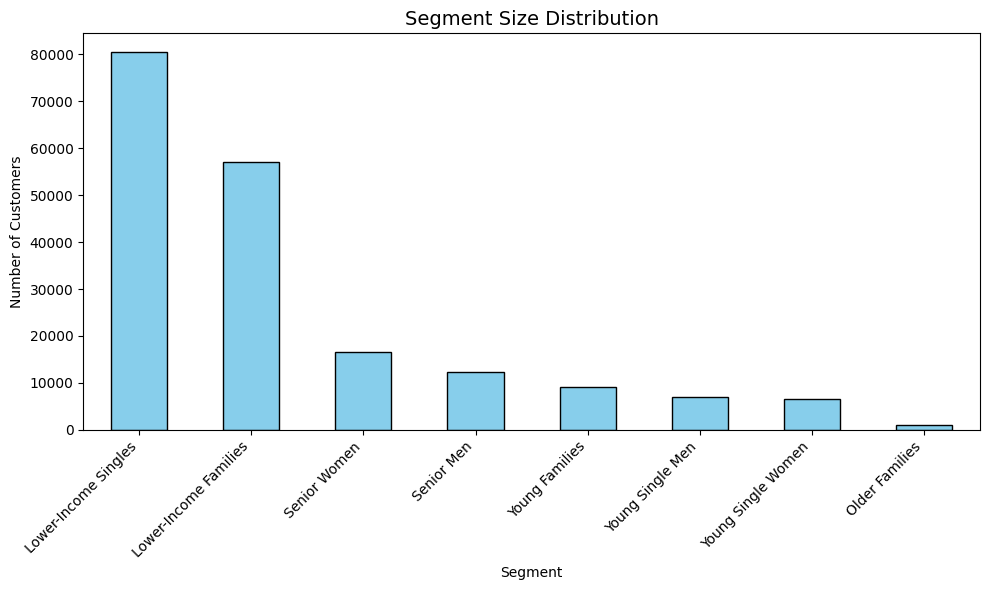

In [ ]:

# Visualizations 

# Segment distribution 

plt.figure(figsize=(10, 6))
df_cluster['Segment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Segment Size Distribution', fontsize=14)
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

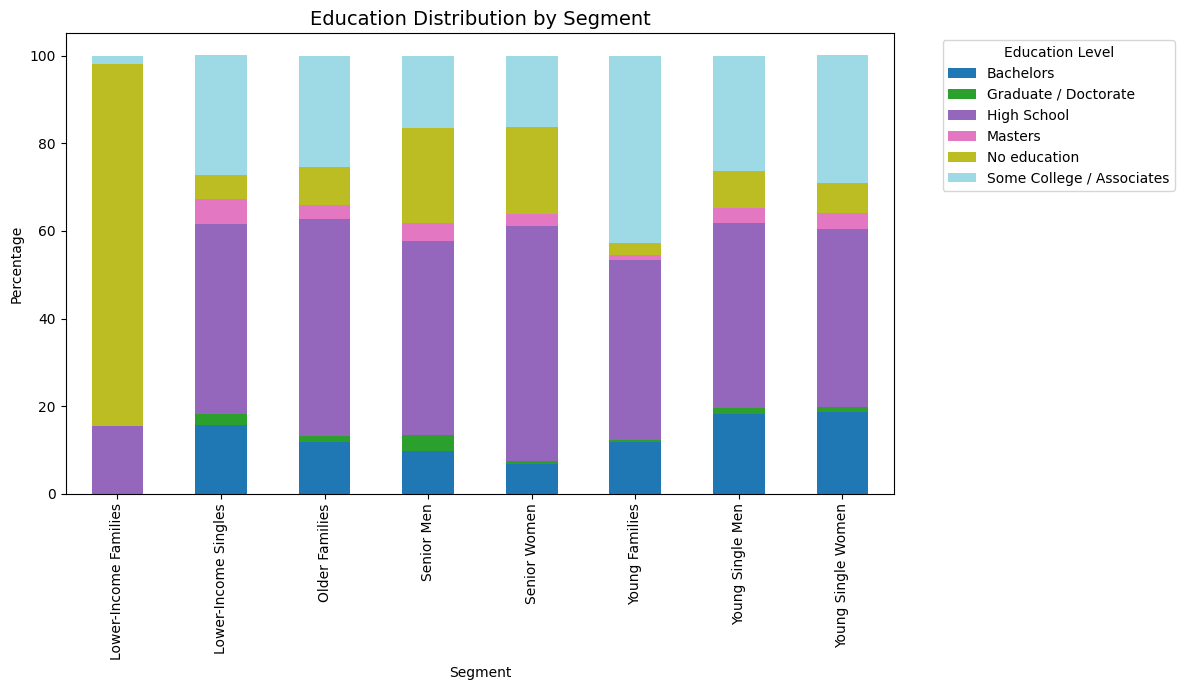

In [39]:
# Education Distribution

education_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='tab20')
plt.title('Education Distribution by Segment', fontsize=14)
plt.ylabel('Percentage')
plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

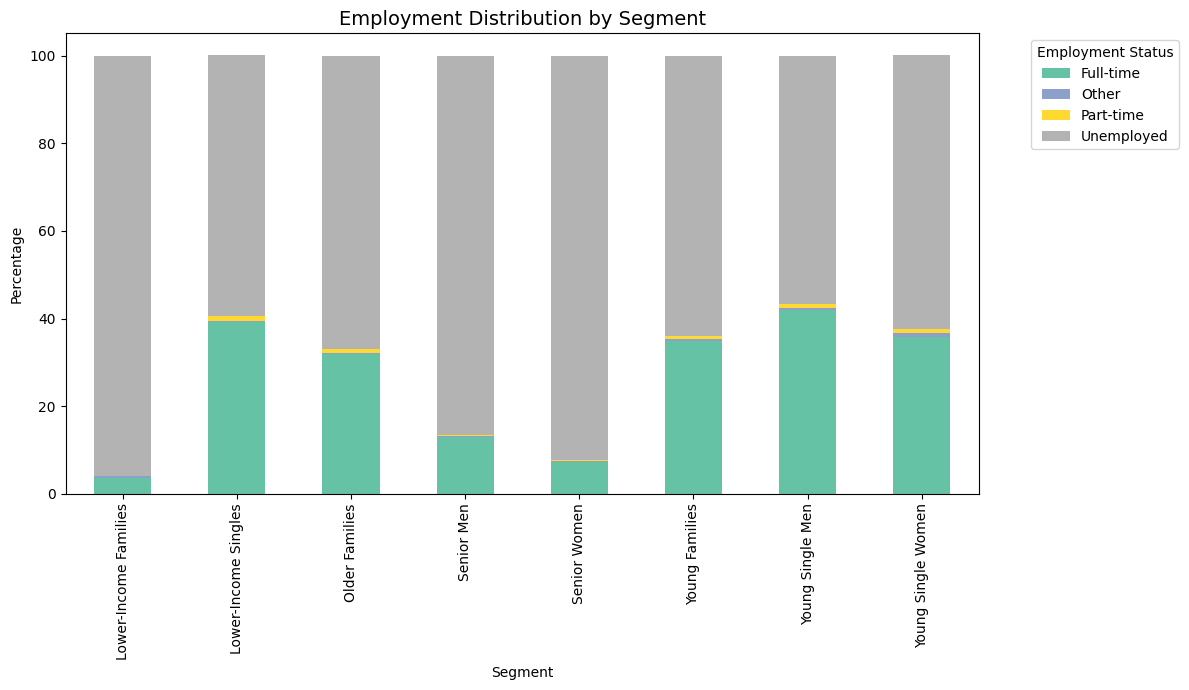

In [40]:
# Employment Distribution
employment_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Set2')
plt.title('Employment Distribution by Segment', fontsize=14)
plt.ylabel('Percentage')
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

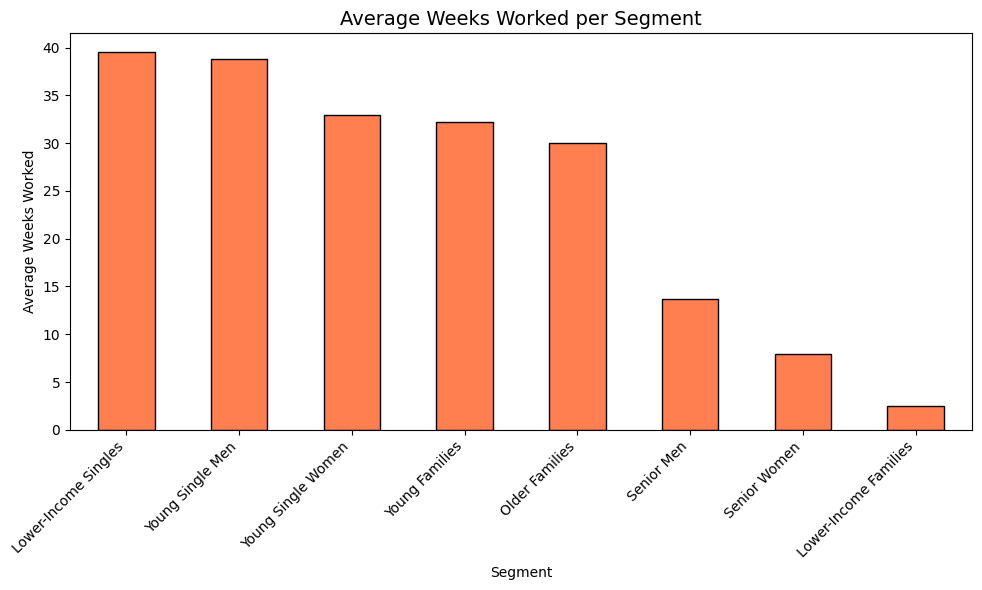

In [41]:
# Average Weeks Worked by Segment

plt.figure(figsize=(10, 6))
numeric_summary['weeks worked in year'].sort_values(ascending=False).plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Weeks Worked per Segment', fontsize=14)
plt.ylabel('Average Weeks Worked')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Empirical Analysis with K-Means 

In [ ]:
''' 
Since there is no way to actually validate a rule-based segmentation model, I tried validating it with K-means clustering
to give it some empirical basis. The important thing to note here is that K-means clusters and my segments are 
MUTUALLY EXCLUSIVE to avoid any sort of bias. 
'''

# Gathering columns for clustering

## Gathering binned columns

bin_prefix = ["marital_bin_", "family_bin_", "household_bin_", "race_bin_", "hispanic_bin_", "sex_"]

bin_prefix_cols = []

for pref in bin_prefix:
    bin_prefix_cols.extend([col for col in X_train_enc.columns if col.startswith(pref)])

## Gathering remaining cols

ord_cols = ['age_bins', 'education_bin', 'employment_bin']
num_cols = ['weeks worked in year', 'log_wage_per_hour', 'log_investment_income', 'num persons worked for employer']
binary_cols = ['is_tax_filer']


clustering_features = ord_cols + num_cols + binary_cols + bin_prefix_cols

print(clustering_features)

['age_bins', 'education_bin', 'employment_bin', 'weeks worked in year', 'log_wage_per_hour', 'log_investment_income', 'num persons worked for employer', 'is_tax_filer', 'marital_bin_Married', 'marital_bin_Never Married', 'marital_bin_Previously Married', 'family_bin_Children (18+)', 'family_bin_Children (_lt_18)', 'family_bin_Head of Household', 'family_bin_Non-family', 'family_bin_Spouse', 'household_bin_Children (18+)', 'household_bin_Children (_lt_18)', 'household_bin_Householder', 'household_bin_Other', 'household_bin_Spouse', 'race_bin_Asian or Pacific Islander', 'race_bin_Black', 'race_bin_Other', 'race_bin_White', 'hispanic_bin_Mexican', 'hispanic_bin_Non-Hispanic', 'hispanic_bin_Other Hispanic', 'hispanic_bin_Unknown', 'sex_Female', 'sex_Male']


In [ ]:
# Standardize the columns for clustering

X_train_seg = X_train_enc[clustering_features].copy()
scaler = StandardScaler()

X_train_seg_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_seg),
    columns = clustering_features,
    index = X_train_seg.index
)

print(X_train_seg_scaled.shape)

(152321, 31)


In [ ]:

k_final = 7  # For 7 rule-based segments

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans.fit(X_train_seg_scaled)

# Assign cluster labels 
# Note: It is only for those rows that align with the df_cluster dataset. K-means was trained on the scaled dataset

df_cluster.loc[X_train_seg_scaled.index, 'kmeans_cluster'] = kmeans.labels_

# Check distribution of clusters
print("K-Means Cluster Distribution:")
print(df_predictive['kmeans_cluster'].value_counts().sort_index())


K-Means Cluster Distribution:
kmeans_cluster
0.0    32249
1.0    42791
2.0    18669
3.0    11070
4.0     8975
5.0      229
6.0    38338
Name: count, dtype: int64


In [ ]:
# Comparison with rule-based segmentation

comparison_table = pd.crosstab(df_cluster['Segment'], df_cluster['kmeans_cluster'])
comparison_pct = pd.crosstab(df_cluster['Segment'], df_cluster['kmeans_cluster'], normalize='index') * 100

print("\nCluster Distribution by Rule-Based Segment")
print(comparison_table)

print("\nPercentage Overlap")
print(comparison_pct.round(2))


=== Cluster Distribution by Rule-Based Segment ===
kmeans_cluster           0.0    1.0   2.0   3.0   4.0  5.0    6.0
Segment                                                          
Lower-Income Families      0  42762     0  2888    13   51      0
Lower-Income Singles   25967      4  9396     2  2967   97  25951
Older Families             0      0     0   847     0    1      0
Senior Men               943      0  1625    45   361   14   6931
Senior Women            5339      0  6165    62  1111   37    608
Young Families             0      0     0  7226     0    9      0
Young Single Men           0     16    33     0  2488   13   3072
Young Single Women         0      9  1450     0  2035    7   1776

=== Percentage Overlap (Row %) ===
kmeans_cluster           0.0    1.0    2.0    3.0    4.0   5.0    6.0
Segment                                                              
Lower-Income Families   0.00  93.54   0.00   6.32   0.03  0.11   0.00
Lower-Income Singles   40.33   0.01  14.59

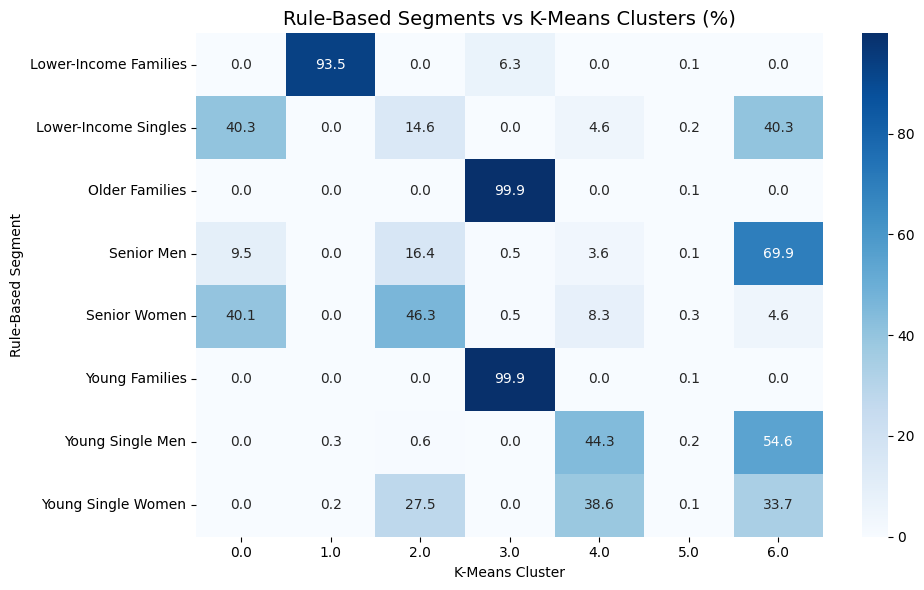

In [ ]:
# Heatmap for comparison

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Rule-Based Segments vs K-Means Clusters (%)", fontsize=14)
plt.ylabel("Rule-Based Segment")
plt.xlabel("K-Means Cluster")
plt.tight_layout()
plt.show()